In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import json
import imageio
import os
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from utils.preprocessing import process_example
from pympler import asizeof
from collections import Counter
from data_augumentation.augument import augumentate
import mplcursors
from abnormals import abnormal_samples_21

In [46]:
# normalize the data to have same starting pt for all time series
# input shape: (n_samples, n_timepoints, width, height), want each samples - its mean of 0-30th timepts
def normalize_curves_mean_method(unnormalized_data):
    mean = np.mean(unnormalized_data[:30, :, :], axis=0, keepdims=True)
    normalized_data = np.maximum(unnormalized_data - mean, 0)
    assert normalized_data.shape == unnormalized_data.shape, 'Shape mismatch after normalization'
    return normalized_data

In [47]:
target_size = 21
target_cultivar = 'RIES'


round_numbers = [5, 6]
 # npy data path -> {'label': 0/1, 'cultivar': 'cultivar_name'}
total_video_map = {}



for round_number in round_numbers:
    roi_data_folder = f'C:/Users/Mud/Desktop/2ndPaper/roi_data/size-{target_size}/round_{round_number}/abnormal/'
    data_status_csv = f'C:/Users/Mud/Desktop/2ndPaper/roi_data/csv/stat_all_data_extend_mean_normalization_pca_round_{round_number}.csv'

   
    # Load the data status
    data_status = pd.read_csv(data_status_csv)
    data_status_this_round = data_status[data_status['dev_stage'] == round_number]


    # Load the data and append without flattening
    for index, row in data_status_this_round.iterrows():
        filename = row['filename']
        cultivar = row['cultivar']
        mortality = row['mortality']
        treatment = row['treatment']
        npy_data_path = f'{roi_data_folder}[ROI]{filename}'
        try:
            video_data = np.load(npy_data_path)

            if cultivar == target_cultivar:

                if 1 <= treatment < 5:
                    if mortality:
                        total_video_map[npy_data_path] = {'label': 1, 'cultivar': cultivar}
                    else:
                        total_video_map[npy_data_path] = {'label': 0, 'cultivar': cultivar}
                    print(f'Loaded {filename} with shape {video_data.shape}')
        except FileNotFoundError:
            print(f'File not found: {npy_data_path}, possibly an good data and not interesting for us')

File not found: C:/Users/Mud/Desktop/2ndPaper/roi_data/size-21/round_5/abnormal/[ROI]CF5.0_B01_N06.npy, possibly an good data and not interesting for us
File not found: C:/Users/Mud/Desktop/2ndPaper/roi_data/size-21/round_5/abnormal/[ROI]CF5.0_B02_N02.npy, possibly an good data and not interesting for us
File not found: C:/Users/Mud/Desktop/2ndPaper/roi_data/size-21/round_5/abnormal/[ROI]CF5.0_B02_N05.npy, possibly an good data and not interesting for us
File not found: C:/Users/Mud/Desktop/2ndPaper/roi_data/size-21/round_5/abnormal/[ROI]CF5.0_B02_N06.npy, possibly an good data and not interesting for us
File not found: C:/Users/Mud/Desktop/2ndPaper/roi_data/size-21/round_5/abnormal/[ROI]CF5.0_B02_N08.npy, possibly an good data and not interesting for us
File not found: C:/Users/Mud/Desktop/2ndPaper/roi_data/size-21/round_5/abnormal/[ROI]CF5.0_B02_N09.npy, possibly an good data and not interesting for us
File not found: C:/Users/Mud/Desktop/2ndPaper/roi_data/size-21/round_5/abnormal/[R

In [48]:
print('shape of total_video_map:', len(total_video_map.values()))

shape of total_video_map: 38


In [49]:
# cultivar-specific data
video_paths = list(total_video_map.keys())
labels = [total_video_map[path]['label'] for path in video_paths]
X = pd.DataFrame(index=video_paths)  # empty DataFrame with video paths as index
y = pd.Series(labels, index=video_paths)
test_videos, test_labels = X, y
test_video_to_label_map = test_labels.to_dict()

print('Test:', test_videos.shape, test_labels.shape)

# Count class distribution
print("\nClass distribution:")
print("\nTest:")
print(test_labels.value_counts())

Test: (38, 0) (38,)

Class distribution:

Test:
1    24
0    14
Name: count, dtype: int64


In [50]:
%matplotlib widget

def normalize_curve_mean_method1(input_data):
    mean = np.mean(input_data[:30])
    normalized_data = np.maximum(input_data - mean, 0)
    return normalized_data


def visualizer(label_map, random_state=42, random_pick_num=-1):
    video_paths = list(label_map.keys())
    total_samples = len(video_paths)

    # Randomly sample video paths
    random.seed(random_state)
    if random_pick_num == -1:
        random_pick_num = total_samples
    sampled_paths = random.sample(video_paths, min(random_pick_num, total_samples))

    plt.figure(figsize=(10, 5))
    lines = []
    for video_path in sampled_paths:
        video_array = np.load(video_path)
        video_curve = np.mean(video_array, axis=(1, 2))
        video_curve = normalize_curve_mean_method1(video_curve)
        label = label_map[video_path]
        line, = plt.plot(
            video_curve,
            color={0: 'blue', 1: 'red'}.get(label),
            alpha=0.5
        )
        line._video_path = video_path  # Attach metadata
        lines.append(line)

    plt.xlabel('Frame')
    plt.ylabel('Mean Value')
    plt.title('Time-Series Curves of Randomly Picked Videos')

    # Add hover annotations
    cursor = mplcursors.cursor(lines, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set(text=f"{os.path.basename(sel.artist._video_path)}")

    plt.tight_layout()
    plt.show()

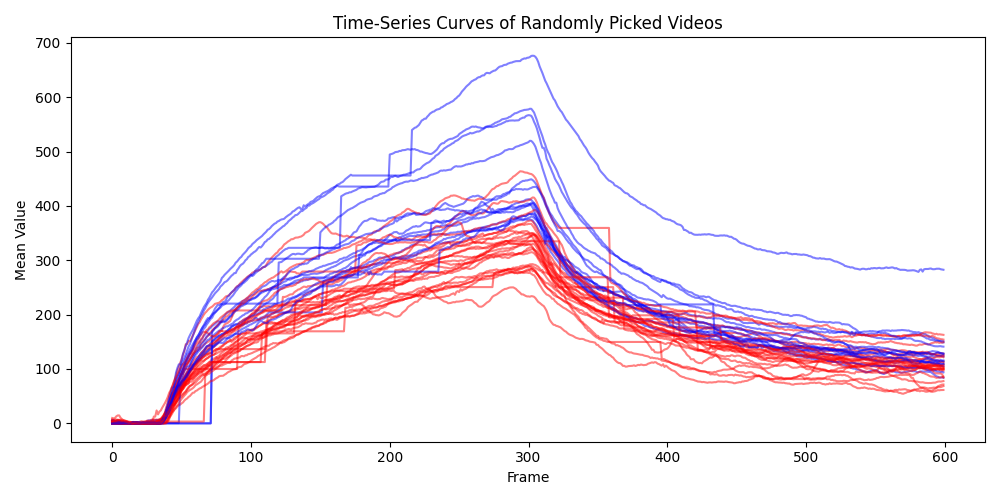

In [51]:
visualizer(test_video_to_label_map, random_state=42, random_pick_num=-1)

In [52]:
min_max_dict = {
    "CF": [0.0, 832.1333333333332],
    "CON": [0.0, 758.1333333333332],
    "PN": [0.0, 1003.8666666666668],
    "RIES": [0.0, 1132.3999999999996],
}
global_min, global_max = min_max_dict[target_cultivar][0], min_max_dict[target_cultivar][1]
print(f'Global min: {global_min}, Global max: {global_max}')

def prepare_data(video_to_label_map, data_type='train'):
    # Compute global min and max across all videos
    pixel_values = [np.load(path) for path in video_to_label_map]
    pixel_values = [normalize_curves_mean_method(video) for video in pixel_values]

    # Normalize and convert videos
    data = []
    for video, (video_path, label) in zip(pixel_values, video_to_label_map.items()):
        normalized = ((video - global_min) / (global_max - global_min) * 255).astype(np.uint8)
        rgb_video = np.stack([cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB) for frame in normalized], axis=0)
        data.append({'video': rgb_video, 'labels': label})

    # find the max/min val of all pixels in the video
    mins, maxs = [], []
    for video in data:
        rgb_video = video['video']
        mins.append(rgb_video.min())
        maxs.append(rgb_video.max())
    print(f'Min of all videos: {min(mins)}, Max of all videos: {max(maxs)}')
    return data

test_video_dict_list = prepare_data(test_video_to_label_map, data_type='test')

Global min: 0.0, Global max: 1132.3999999999996
Min of all videos: 0, Max of all videos: 200


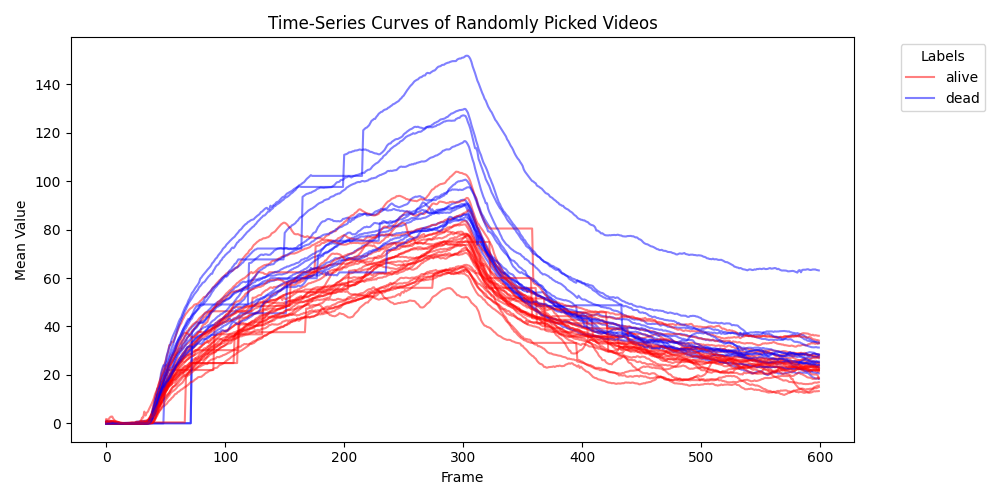

In [53]:
def visualizer2(video_dict_list, random_state=42, random_pick_num=-1):
    total_samples = len(video_dict_list)

    # Randomly select indices
    random.seed(random_state)
    if random_pick_num == -1:
        random_pick_num = total_samples
    indices = random.sample(range(total_samples), min(random_pick_num, total_samples))

    plt.figure(figsize=(10, 5))
    for idx in indices:
        video_dict = video_dict_list[idx]['video']
        label = video_dict_list[idx]['labels']
        video_curve = np.mean(video_dict_list[idx]['video'], axis=(1, 2, 3))
        plt.plot(video_curve, color={0: 'blue', 1: 'red'}.get(label), alpha=0.5, label=f'dead' if label == 0 else 'alive')
    plt.xlabel('Frame')
    plt.ylabel('Mean Value')
    plt.title('Time-Series Curves of Randomly Picked Videos')

    # Deduplicate legend entries
    handles, labels_unique = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels_unique, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

visualizer2(test_video_dict_list, random_state=42)

In [54]:
mins, maxs = [], []
for video_dict in test_video_dict_list:
    data = video_dict['video']
    data = np.concatenate(data, axis=0)
    mins.append(data.min())
    maxs.append(data.max())
print(f'Min of all videos: {min(mins)}, Max of all videos: {max(maxs)}')

Min of all videos: 0, Max of all videos: 200


In [55]:
def downsample_video(video_dict, target_total_frames=600):
    if target_total_frames == 600:
        return video_dict['video']
    video = video_dict['video']
    total_frames = video.shape[0]
    # Downsample by taking every nth frame
    step = total_frames // target_total_frames
    video = video[::step][:target_total_frames]
    return video

def find_max_min(video_dict):
    data = [video_dict['video']]
    data = np.concatenate(data, axis=0)
    print(f'Min of all videos: {data.min()}, Max of all videos: {data.max()}')

def find_max_min1(processed):
    data = processed['pixel_values']
    print(f'Min of all videos: {data.min()}, Max of all videos: {data.max()}')

def create_pytorch_ds_and_store(video_dict_list, save_dir, type):
    os.makedirs(save_dir, exist_ok=True)
    metadata = []

    # Downsample videos
    for video_dict in tqdm(video_dict_list, desc=f"Downsampling {type} data"):
        video_dict['video'] = downsample_video(video_dict, target_total_frames=60)


    # Create Dataset object
    for i, video_dict in enumerate(tqdm(video_dict_list, desc=f"Processing {type} data using image-processer and saving")):
        # find_max_min(video_dict)
        processed = process_example(video_dict)
        processed["pixel_values"] = processed["pixel_values"].squeeze(0) # remove batch dimension [1, T, C, H, W] → [T, C, H, W]
        # find_max_min1(processed)
        file_path = os.path.join(save_dir, f"sample_{i}.pt")
        torch.save({
            "pixel_values": processed["pixel_values"],  # [600, 3, 224, 224]
            "labels": processed["labels"]
        }, file_path)
        metadata.append({ "path": file_path })
        

    with open(os.path.join(save_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f)



test_dataset = create_pytorch_ds_and_store(test_video_dict_list, save_dir=f'./refined_data_{target_size}/{target_cultivar}/frame-60/abnormal/test', type='test')

Downsampling test data: 100%|██████████| 38/38 [00:00<?, ?it/s]
Processing test data using image-processer and saving: 100%|██████████| 38/38 [00:23<00:00,  1.65it/s]


In [56]:
class VideoDiskDataset(torch.utils.data.Dataset):
    def __init__(self, metadata_path):
        with open(metadata_path, "r") as f:
            self.metadata = json.load(f)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        item = torch.load(self.metadata[idx]["path"])
        return {
            "pixel_values": item["pixel_values"],  # shape: [T, 3, 224, 224]
            "labels": item["labels"]
        }

test_dataset  = VideoDiskDataset(f'./refined_data_{target_size}/{target_cultivar}/frame-60/abnormal/test/metadata.json')

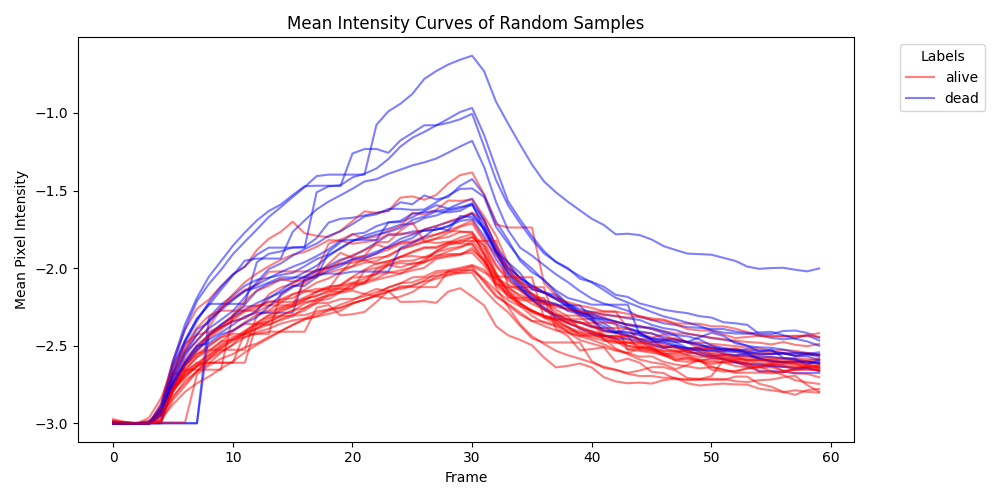

In [57]:
def visualizer3(dataset, random_state=42, random_pick_num=-1):
    total_samples = len(dataset)

    # Randomly select sample indices
    random.seed(random_state)
    if random_pick_num == -1:
        random_pick_num = total_samples
    indices = random.sample(range(total_samples), min(random_pick_num, total_samples))

    plt.figure(figsize=(10, 5))

    for idx in indices:
        sample = dataset[idx]
        pixel_values = sample['pixel_values']  # shape: [T, C, H, W]
        label = sample['labels']

        # Convert to numpy and calculate mean intensity per frame
        video_np = pixel_values.numpy()  # [T, C, H, W]
        video_mean_curve = np.mean(video_np, axis=(1, 2, 3))  # [T]

        # Plot the curve
        plt.plot(
            video_mean_curve,
            color={0: 'blue', 1: 'red'}.get(label, 'gray'),
            alpha=0.5,
            label='dead' if label == 0 else 'alive'
        )

    plt.xlabel('Frame')
    plt.ylabel('Mean Pixel Intensity')
    plt.title('Mean Intensity Curves of Random Samples')

    # Deduplicate legend
    handles, labels_uniq = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels_uniq, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

visualizer3(test_dataset, random_state=42)